In [1]:
# Necassary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from datetime import timedelta
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# pymysql to connect to Database
import pymysql

In [2]:
# Making the conn object and cursor
conn = pymysql.connect(
    host = 'localhost',
    user = 'root',
    password = '1123',
    database = 'miniproject'
)

In [3]:
query = "SELECT * FROM tweet"

In [9]:
tweets_data = pd.read_sql(query, conn)

In [11]:
tweets_data.head()

,TWEET,Geo,latitude,logitude,id,created_at,retweet_count,coordinates
0,94742: Stationary Vehicle on N3 Eastbound afte...,"{'coordinates': [-29.60896477, 30.40999199], '...",-29.608965,30.409992,1.246100e+18,Fri Apr 03 15:44:56 +0000 2020,0,"{'coordinates': [30.40999199, -29.60896477], '..."
1,"Nepean Hwy , Brighton - Traffic Alert, Two lan...","{'coordinates': [-37.89742093, 145.00556709], ...",-37.897421,145.005567,1.246000e+18,Fri Apr 03 09:03:02 +0000 2020,0,"{'coordinates': [145.00556709, -37.89742093], ..."
2,"Racecourse Rd , North Melbourne - Traffic Aler...","{'coordinates': [-37.7891756, 144.94003075], '...",-37.789176,144.940031,1.245970e+18,Fri Apr 03 07:06:02 +0000 2020,0,"{'coordinates': [144.94003075, -37.7891756], '..."
3,"Canterbury Rd , Bayswater North - Traffic Aler...","{'coordinates': [-37.83217074, 145.26937039], ...",-37.832171,145.269370,1.245870e+18,Fri Apr 03 00:06:02 +0000 2020,0,"{'coordinates': [145.26937039, -37.83217074], ..."
4,94730: Stationary Vehicle on N3 Westbound afte...,"{'coordinates': [-29.82234686, 30.8069087], 't...",-29.822347,30.806909,1.245830e+18,Thu Apr 02 21:31:14 +0000 2020,0,"{'coordinates': [30.8069087, -29.82234686], 't..."


In [15]:
tweets_data['created_at'] = pd.to_datetime(tweets_data['created_at'])

tweets_data['hour'] = tweets_data['created_at'].dt.floor('H')

tweet_frequency = tweets_data.groupby('hour').size().reset_index(name='tweet_count')

tweet_frequency.head()

,hour,tweet_count
0,2020-03-27 12:00:00+00:00,3
1,2020-03-27 13:00:00+00:00,33
2,2020-03-27 14:00:00+00:00,21
3,2020-03-27 15:00:00+00:00,16
4,2020-03-27 16:00:00+00:00,19


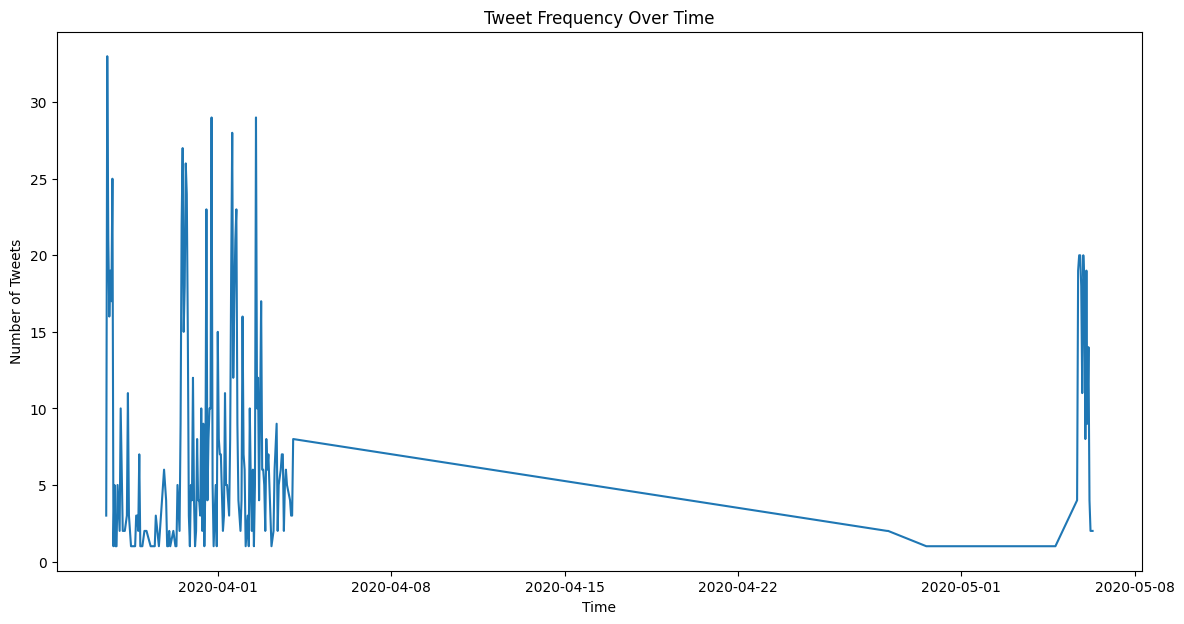

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(tweet_frequency['hour'], tweet_frequency['tweet_count'])
plt.title('Tweet Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')
plt.show()

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tweet_frequency['tweet_count'].values.reshape(-1, 1))

def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 24

X, Y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

training_size = int(len(X) * 0.8)
X_train, X_test = X[:training_size], X[training_size:]
Y_train, Y_test = Y[:training_size], Y[training_size:]

In [20]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=False))
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping])


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0782 - val_loss: 0.0553
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0555 - val_loss: 0.0551
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0408 - val_loss: 0.0495
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0559 - val_loss: 0.0488
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0515 - val_loss: 0.0511
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0505 - val_loss: 0.0511
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0475 - val_loss: 0.0487
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0520 - val_loss: 0.0483
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0515 - val_loss: 0.0482
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0528 - val_loss: 0.0489
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0497 - val_loss: 0.0493
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0521 - val_l

In [22]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse the scaling to view predictions unscaled
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


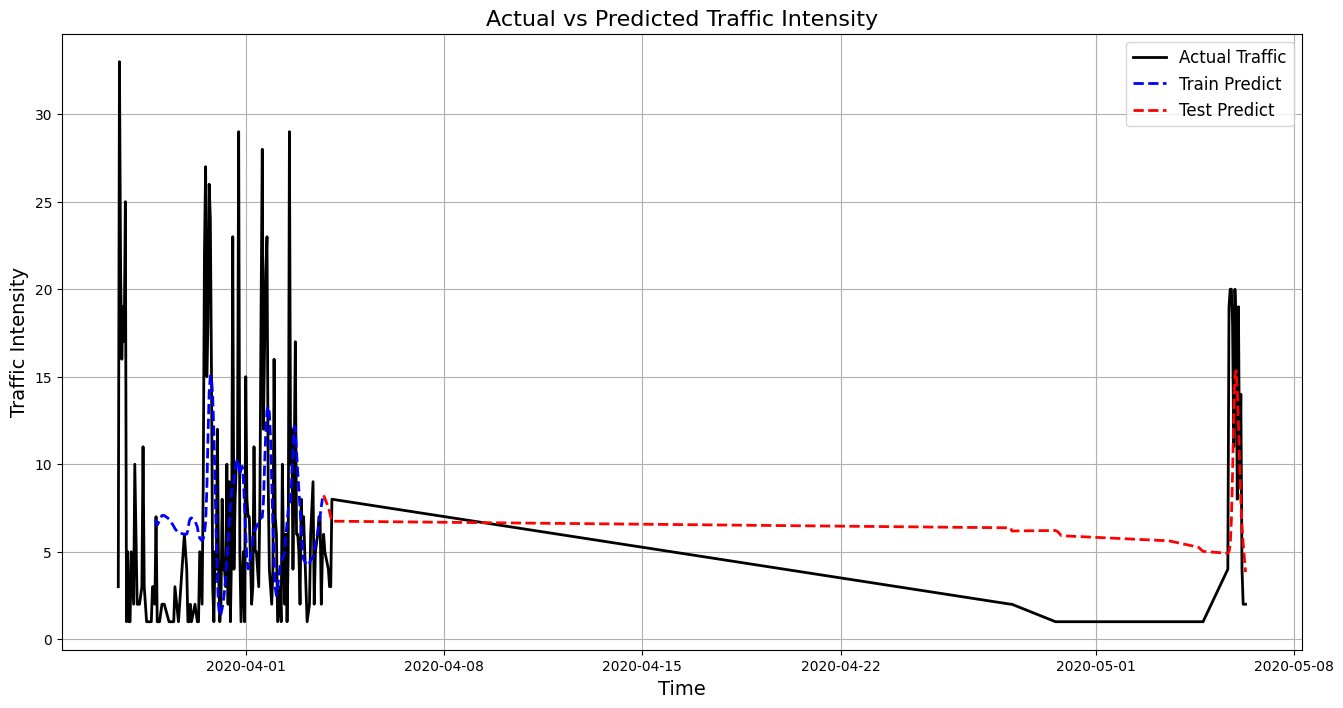

In [23]:
plt.figure(figsize=(16, 8))

plt.plot(tweet_frequency['hour'], tweet_frequency['tweet_count'], label='Actual Traffic', color='black', linewidth=2)

plt.plot(tweet_frequency['hour'][time_step+1:len(train_predict)+time_step+1], train_predict,
         label='Train Predict', color='blue', linestyle='--', linewidth=2)

plt.plot(tweet_frequency['hour'][len(train_predict)+time_step+1:], test_predict,
         label='Test Predict', color='red', linestyle='--', linewidth=2)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Traffic Intensity', fontsize=14)
plt.title('Actual vs Predicted Traffic Intensity', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [24]:
train_r2 = r2_score(tweet_frequency['tweet_count'][time_step+1:len(train_predict)+time_step+1], train_predict)
train_mse = mean_squared_error(tweet_frequency['tweet_count'][time_step+1:len(train_predict)+time_step+1], train_predict)


test_r2 = r2_score(tweet_frequency['tweet_count'][len(train_predict)+time_step+1:], test_predict)
test_mse = mean_squared_error(tweet_frequency['tweet_count'][len(train_predict)+time_step+1:], test_predict)


print(f"Training R²: {train_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Testing R²: {test_r2:.4f}")
print(f"Testing MSE: {test_mse:.4f}")

Training R²: 0.1306
Training MSE: 42.2731
Testing R²: 0.2852
Testing MSE: 35.7612


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


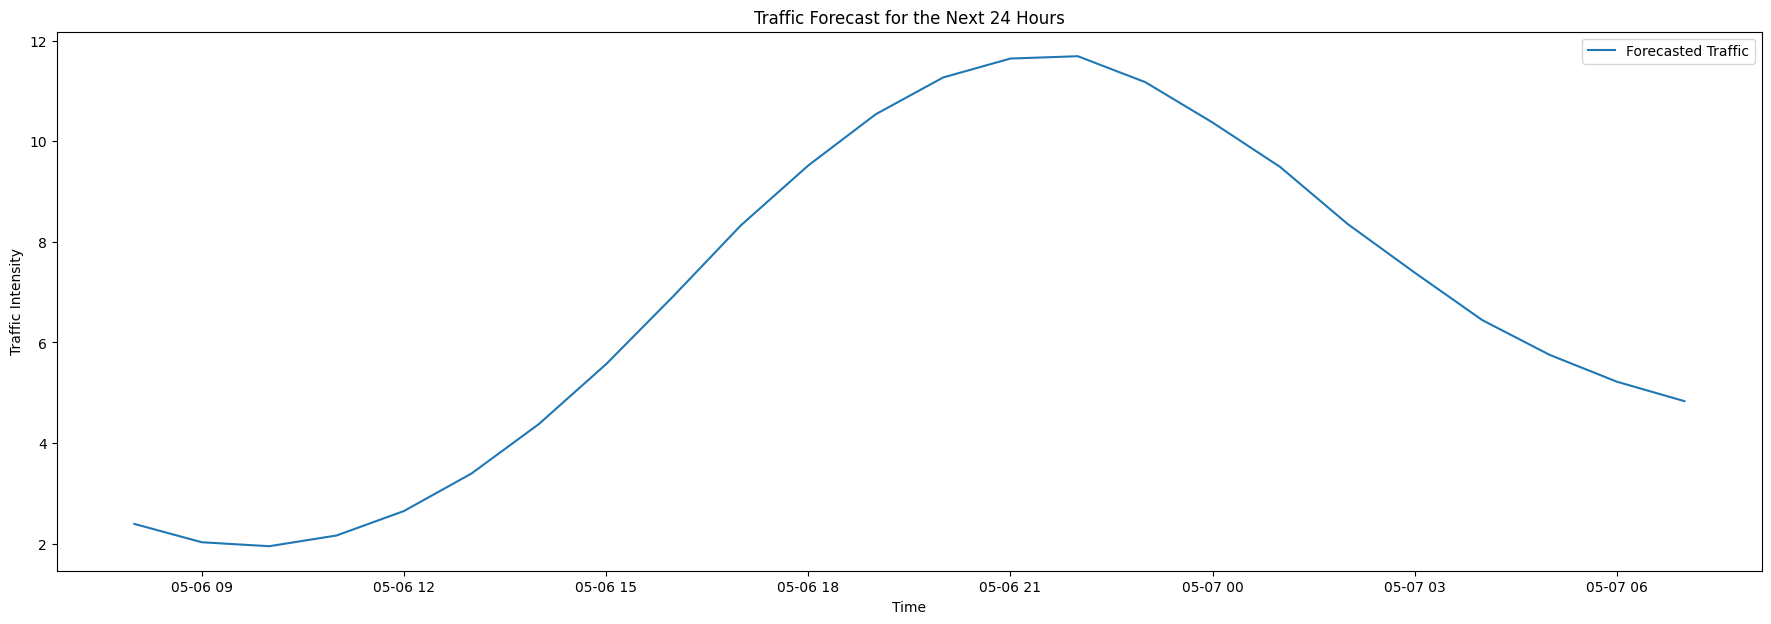

In [25]:
last_hours = scaled_data[-time_step:]
forecast_input = last_hours.reshape((1, time_step, 1))

forecast_output = []

for _ in range(24):
    prediction = model.predict(forecast_input)
    forecast_output.append(prediction[0, 0])

    forecast_input = np.roll(forecast_input, shift=-1, axis=1)
    forecast_input[0, -1, 0] = prediction

forecast_output = scaler.inverse_transform(np.array(forecast_output).reshape(-1, 1))

forecast_dates = pd.date_range(tweet_frequency['hour'].iloc[-1] + timedelta(hours=1), periods=24, freq='H')

plt.figure(figsize=(22, 7))
plt.plot(forecast_dates, forecast_output, label='Forecasted Traffic')
plt.xlabel('Time')
plt.ylabel('Traffic Intensity')
plt.title('Traffic Forecast for the Next 24 Hours')
plt.legend()
plt.show()